In [ ]:
!pip install PySpark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 9.8 MB/s eta 0:00:00
  Created wheel for PySpark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=57285b18b5c971886bd3770dd7f04ee19b1cce1ff769ebd5f6ebb1c97aa19ac5
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built PySpark


In [19]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pyspark.pandas as ps

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
spark = SparkSession.builder.appName("bike").getOrCreate()
df = spark.read.option("header","true").csv("/content/gdrive/MyDrive/Colab Notebooks/2017-fordgobike-tripdata.csv")

In [22]:
df = df.withColumn("starttime", unix_timestamp(col("start_time"), "mm:ss.S").cast(TimestampType()))
df = df.withColumn("endtime", unix_timestamp(col("end_time"), "mm:ss.S").cast(TimestampType()))

df = df.withColumn("duration", expr("if(\
(unix_timestamp(endtime) - unix_timestamp(starttime)) >= 0, \
(unix_timestamp(endtime) - unix_timestamp(starttime)), \
(unix_timestamp(endtime) + 3600 - unix_timestamp(starttime)))").cast("integer"))

df = df.withColumn("duration", expr("if(\
(unix_timestamp(endtime) - unix_timestamp(starttime)) >= 0, \
(unix_timestamp(endtime) - unix_timestamp(starttime)), \
(unix_timestamp(endtime) + 3600 - unix_timestamp(starttime)))").cast("timestamp"))

df = df.withColumn("duration_second", minute(col("duration")))
df = df.withColumn("fee_of_trip", bround(col("duration_second") * 0.35, 2))

In [29]:
total_cost = df.groupBy("user_type").agg({'fee_of_trip' : 'sum'}).withColumnRenamed("sum(fee_of_trip)", "Total Cost")

In [31]:
total_cost = total_cost.withColumn("Total Cost", round(total_cost["Total Cost"], 2))
total_cost.show()

+----------+----------+
| user_type|Total Cost|
+----------+----------+
|Subscriber|1417162.95|
|  Customer|  731636.5|
+----------+----------+



In [33]:
total_cost_pandas = total_cost.toPandas()

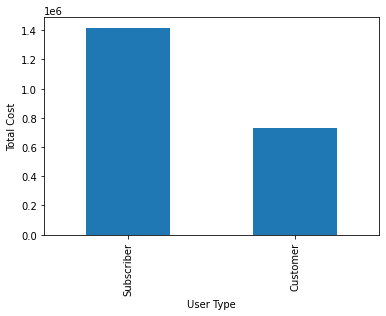

In [34]:
final_cost = total_cost_pandas.plot(kind='bar', x='user_type', y='Total Cost', legend=False)
final_cost.set_xlabel("User Type")
final_cost.set_ylabel("Total Cost")
plt.show()